In [43]:
import sys
import matplotlib.colors as clr
import numpy as np
from GCRCatalogs.helpers.tract_catalogs import tract_filter, sample_filter
import matplotlib.pyplot as plt
import os
from GCR import GCRQuery
from astropy.io import fits
import fitsio as fio
import glob
from tqdm import tqdm
from numpy import random
import GCRCatalogs
from catalog import Catalog

In [58]:
# Plotting function
def plot_c_cs_z(data,z_name,mag_name,subset = None):
    f,axes = plt.subplots(4,1,sharex= True,figsize = (5,8))
    fr = ['g','r','i','z','y']
    plt.subplots_adjust(hspace=0.0)
    for i,ax in enumerate(axes):
        ax.set_ylabel((r'$%s-%s$')%(fr[i],fr[i+1]),fontsize = 15)
        if subset is not None:
            ax.plot(data[z_name][subset],(data[mag_name%fr[i]][subset] 
                            - data[mag_name%fr[i+1]][subset]),'.',markersize = 1)
        else:
            ax.plot(data[z_name],(data[mag_name%fr[i]] 
                            - data[mag_name%fr[i+1]]),'.',markersize = 1)
    ax.set_xlabel(r'$z_{spec}$',fontsize = 15);

## Load cosmoDC2 redmagic sample

In [59]:
gc = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_redmagic_v0.8.1_highlum')

cuts = [
    GCRQuery('ra > 51'),
    GCRQuery('ra < 56'),
    GCRQuery('dec > -42'),
    GCRQuery('dec < -38'),
    GCRQuery('zspec < 1.2')
]
data_red = gc.get_quantities([ 'id', 'redshift','mag_y_lsst','zspec','chisq','z_lum','zredmagic_samp_0','redshift_err',
                          'mag_g_lsst','mag_r_lsst','mag_i_lsst','mag_z_lsst',
                          'magerr_g_lsst','magerr_y_lsst','ra','dec',
                         'magerr_r_lsst','magerr_i_lsst','magerr_z_lsst'
                         ],filters=cuts)

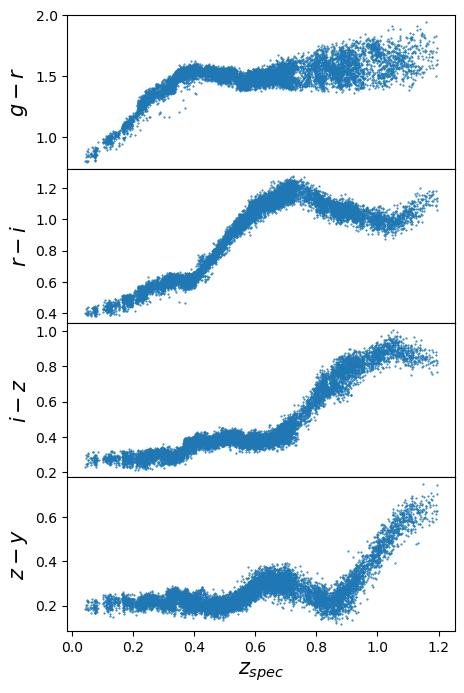

In [60]:
plot_c_cs_z(data = data_red, z_name = 'zspec', mag_name = 'mag_%s_lsst')

## Cross Match the galxies in cosmodc2 redmagic catalog above to cosmoDC2 truth information

In [2]:
# This may take a while to run...
gc = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image')
cuts = [
    GCRQuery('ra > 51'),
    GCRQuery('ra < 56'),
    GCRQuery('dec > -42'),
    GCRQuery('dec < -38'),
    GCRQuery('redshift_true <= 1.2'),
]

data = gc.get_quantities([  'galaxy_id','redshift','mag_true_y_lsst','redshift_true',
                          'mag_true_g_lsst','mag_true_r_lsst','mag_true_i_lsst','mag_true_z_lsst',
                          'mag_g_lsst','mag_r_lsst','mag_i_lsst','mag_z_lsst','mag_y_lsst'
                         ], filters=cuts)

redmagic_in_cosmodc2 = np.loadtxt('data/redmaigc_highlum_in_cosmodc2.txt').astype(int)

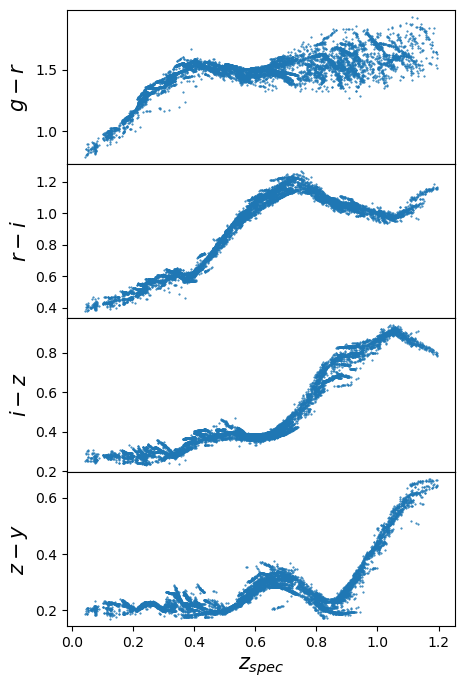

In [13]:
plot_c_cs_z(data = data, z_name = 'redshift', mag_name = 'mag_true_%s_lsst',subset = redmagic_in_cosmodc2)

## Applying Eli's error model to cosmodc2 galaxies to reproduce redmagic colors

In [56]:
def apply_errormodels(maskgals, mag_in, b=None, err_ratio=1.0, fluxmode=False,
    nonoise=False, inlup=False, lnscat=None, sigma0=0.0):
    f1lim = 10.**((maskgals.limmag - maskgals.zp[0])/(-2.5))
    fsky1 = (((f1lim**2.) * maskgals.exptime)/(maskgals.nsig[0]**2.) - f1lim)
    fsky1 = np.clip(fsky1, 0.001, None)

    if inlup:
        bnmgy = b*1e9
        tflux = maskgals.exptime*2.0*bnmgy*np.sinh(-np.log(b)-0.4*np.log(10.0)*mag_in)
    else:
        tflux = maskgals.exptime*10.**((mag_in - maskgals.zp[0])/(-2.5))

    noise = err_ratio*np.sqrt(fsky1*maskgals.exptime + tflux)

    if sigma0 > 0.0:
        noise = np.sqrt(noise**2. + ((np.log(10.)/2.5) * sigma0 * tflux)**2.)

    if lnscat is not None:
        noise = np.exp(np.log(noise) + lnscat * np.random.normal(size=noise.size))

    if nonoise:
        flux = tflux
    else:
        flux = tflux + noise*random.standard_normal(mag_in.size)

    if fluxmode:
        mag = flux/maskgals.exptime
        mag_err = noise/maskgals.exptime
    else:
        if b is not None:
            bnmgy = b*1e9

            flux_new = flux/maskgals.exptime
            noise_new = noise/maskgals.exptime

            mag = 2.5*np.log10(1.0/b) - np.arcsinh(0.5*flux_new/bnmgy)/(0.4*np.log(10.0))
            mag_err = 2.5*noise_new/(2.0*bnmgy*np.log(10.0)*np.sqrt(1.0+(0.5*flux_new/bnmgy)**2.0))
        else:
            # Want to suppress warnings here (because we check for infinites below)
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                mag = maskgals.zp[0]-2.5*np.log10(flux/maskgals.exptime)
                mag_err = (2.5/np.log(10.0))*(noise/flux)

            bad, = np.where(np.isfinite(mag) == False)
            mag[bad] = 99.0
            mag_err[bad] = 99.0

    return mag, mag_err

nmag = 5
# approx errors, design spec 5sigma pt source limits
# grizy
limmag = np.array([25.0,24.7,24.0,23.3,22.1])
# subtract 0.7 pt source to extended and 10 sigma, approx
limmag -= 0.7
# Add 3 for full depth
limmag += 3.0

exptime = np.array([5525.13, 4165.56, 2155.00, 1114.86, 360.201])
lnscat = np.array([0.15, 0.15, 0.15, 0.15, 0.15])
b = np.array([1.4e-12, 0.9e-12, 1.2e-12, 1.8e-12, 7.4e-12])

zp = 22.5
nsig = 10.0

ref_ind = 3

lim_ref = 25.5 # hard-coded

bands = ['g', 'r', 'i', 'z', 'y']


dtype = [('id', 'i8'),
         ('ra', 'f8'),
         ('dec', 'f8'),
         ('refmag', 'f4'),
         ('refmag_err', 'f4'),
         ('mag', 'f4', 5),
         ('mag_err', 'f4', 5),
         ('ztrue', 'f4'),
         ('ebv', 'f4')]

cat = data
subset = redmagic_in_cosmodc2
gals = np.zeros(cat['galaxy_id'][subset].size, dtype=dtype)
gals['id'] = cat['galaxy_id'][subset]
gals['ztrue'] = cat['redshift'][subset]
gals['ebv'] = 0.0

# Need to apply errors here...
for i, band in enumerate(bands):
    inmag = cat['mag_true_%s_lsst' % (band)][subset]

    tempgals = Catalog(np.zeros(inmag.size, dtype=[('limmag', 'f4'),
                                                             ('zp', 'f4'),
                                                             ('exptime', 'f4'),
                                                             ('nsig', 'f4')]))
    tempgals.limmag = limmag[i]
    tempgals.zp = zp
    tempgals.exptime = exptime[i]
    tempgals.nsig = nsig

    mag, magerr = apply_errormodels(tempgals, inmag, b=b[i], lnscat=lnscat[i], sigma0=0.01)

    gals['mag'][:, i] = mag
    gals['mag_err'][:, i] = magerr

gals['refmag'] = gals['mag'][:, ref_ind]
gals['refmag_err'] = gals['mag_err'][:, ref_ind]

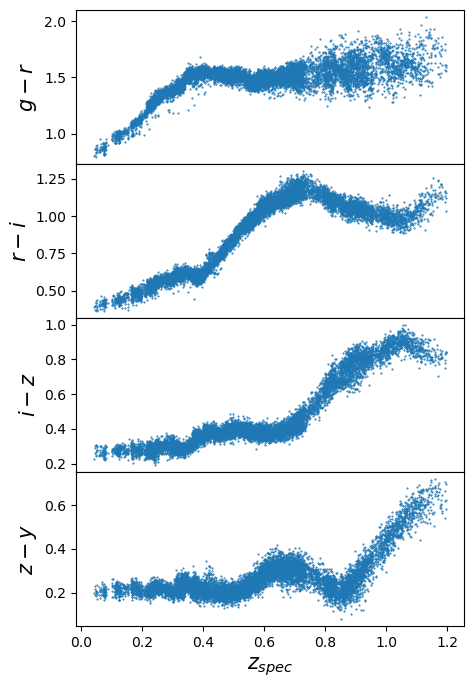

In [57]:
f,axes = plt.subplots(4,1,sharex= True,figsize = (5,8))
fr = ['g','r','i','z','y']
plt.subplots_adjust(hspace=0.0)
for i,ax in enumerate(axes):
    ax.set_ylabel((r'$%s-%s$')%(fr[i],fr[i+1]),fontsize = 15)

    ax.plot(gals['ztrue'],(gals['mag'][:,i] 
                    - gals['mag'][:,i+1]),'.',markersize = 1)
ax.set_xlabel(r'$z_{spec}$',fontsize = 15);